In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from timeit import default_timer as timer
from collections import namedtuple

In [2]:
# Logging

mean_returns, std_devs = [], []

def plot_durations(durations):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [15]:
#========================================================================================#
# Multi-layer perceptron, each layer but the final being rectified
# <dims> is a list of input dimensions
#========================================================================================#
class PolicyNet(nn.Module):
    def __init__(self, dims, discrete):
        super(PolicyNet, self).__init__()
        self.discrete = discrete
        self.n_layers = len(dims) - 1
        ac_dim = dims[-1]
        
        if not discrete:
            self.log_std = nn.Parameter(torch.zeros(1, ac_dim))

        self.linears = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(self.n_layers)])
    
    def forward(self, x):
        if self.n_layers == 1:
            return self.linears[0](x)

        for i in range(self.n_layers - 1):
            x = F.relu(self.linears[i](x))
        
        if self.discrete:
            x = F.log_softmax(self.linears[-1](x), dim=-1)
            return x
        else:
            x = torch.tanh(self.linears[-1](x))
            sigma_sq = torch.exp(self.log_std)
            return x, sigma_sq
        
class Baseline(nn.Module):
    def __init__(self, dims):
        super(Baseline, self).__init__()
        self.n_layers = len(dims) - 1
        self.linears = nn.ModuleList(
            [nn.Linear(dims[i], dims[i+1]) for i in range(self.n_layers)])
    
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = F.relu(self.linears[i](x))
         
        x = self.linears[-1](x)
        return x

In [16]:
pi = torch.FloatTensor([math.pi]) #.to(torch.device("cuda"))

# Return the log-probability of an outcome x given mu and sigma_sq
def log_normal(x, mu, sigma_sq):
    logprobs = -(x-mu).pow(2)/(2*sigma_sq) - 0.5*(2*pi*sigma_sq).log()
    return torch.sum(logprobs, 1)

#========================================================================================#
# Sample an action from a policy network given an observation
#========================================================================================#
def sample_action(policy_net, ob, discrete, device):
    observation = torch.from_numpy(ob).float().to(device)
    
    with torch.no_grad():
        if discrete:
            logits = policy_net(observation)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            return action.item()
        else:
            mu, sigma_sq = policy_net(observation)
            z = torch.randn(mu.size(), device=device)
            action = mu + sigma_sq.sqrt() * z
            return action[0]

In [17]:
#========================================================================================#
# Update network parameters
#========================================================================================#

def update_policy(optimizer, policy_net, ob_no, ac_na, adv_n, n_paths, discrete, device):
            
    optimizer.zero_grad()
    
    if discrete:
        logits = policy_net(ob_no)
        ac_na.unsqueeze_(1)
        logprob_n = logits.gather(1, ac_na).squeeze()
    else:
        mu_na, sigma_sq = policy_net(ob_no.float())
        logprob_n = log_normal(ac_na, mu_na, sigma_sq)
        
    weighted_neg_likelihoods = torch.mul(-logprob_n, adv_n)
    loss = torch.sum(weighted_neg_likelihoods).div(n_paths)
    
    # Optimization step
    loss.backward()
    for p in policy_net.parameters():
        p.grad.data.clamp_(-1, 1)    
    optimizer.step()
    
    return

def update_baseline(optimizer, net, x, target):
    
    # Rescale the targets to have mean zero and std=1
    target = (target - target.mean()) / target.std()
    
    optimizer.zero_grad()
    y = net(x).squeeze()
    lossfn = nn.MSELoss()
    loss = lossfn(y, target)
    loss.backward()
    for p in net.parameters():
        p.grad.data.clamp_(-1, 1)    
    optimizer.step()
    return

In [30]:
# Environment configuration
environments = [
    'CartPole-v0',
    'Pendulum-v0',
    'MountainCar-v0',
    'BipedalWalker-v2',
    'LunarLanderContinuous-v2']

env_name=environments[0]
env = gym.make(env_name)
env.seed(0)
discrete = isinstance(env.action_space, gym.spaces.Discrete) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

# Learning parameters
n_iter=300
max_path_length=env.spec.max_episode_steps
min_timesteps_per_batch=max_path_length*10
gamma=0.99
learning_rate=1e-3
reward_to_go=True
normalize_advantages=True
nn_baseline=True

# Observation and action sizes
ob_dim = env.observation_space.shape[0]
ac_dim = env.action_space.n if discrete else env.action_space.shape[0]

# Network dimensions
pnet_dims = [ob_dim,
             10,
             10,
             ac_dim]
bnet_dims = [ob_dim,
             10,
             10,
             1]

pnet = PolicyNet(pnet_dims, discrete).to(device)
p_optimizer = optim.Adam(pnet.parameters(), lr=learning_rate)

if nn_baseline:
    bnet = Baseline(bnet_dims).to(device)
    b_optimizer = optim.Adam(bnet.parameters(), lr=learning_rate)

In [31]:
total_timesteps = 0
durations, returns = [], []
start = timer()

for itr in range(n_iter):
    #print("********** Iteration %i ************"%itr)  
    timesteps_this_batch = 0
    paths = []
    
    # Collect paths until we have enough timesteps for a batch
    while True:
        obs, acs, rewards = [], [], []
        ob = env.reset()
        steps = 0
        
        # Step through the environment
        while True:
            ob = ob.squeeze()
            obs.append(ob)
            ac = sample_action(pnet, ob, discrete, device)
            if not discrete:
                ac = ac.detach().numpy()
            acs.append(ac)
            ob, rew, done, _ = env.step(ac)
            rewards.append(rew)
            steps += 1
            if done or steps > max_path_length:
                break
        
        path = {"rewards": rewards,
                "actions": acs,
                "observations": obs}
        paths.append(path)
        durations.append(steps)
        returns.append(sum(rewards))
        timesteps_this_batch += steps
        if timesteps_this_batch > min_timesteps_per_batch:
            break

    total_timesteps += timesteps_this_batch
    
    # Calculate the Q-estimates for each step
    if reward_to_go:
        # Make a discounted sum of rewards (reward to go) for each path
        for path in paths:
            rewards = path["rewards"]
            rtogo = np.zeros(len(rewards), dtype=np.float32)
            t = len(rtogo) - 1
            rtogo[t] = rewards[t]
            t -= 1
            while t >= 0:
                rtogo[t] = rewards[t] + gamma * rtogo[t + 1]
                t -= 1
            path["q_n"] = rtogo
    else:
        # Use the discounted path total for each step
        for path in paths:
            rewards = path["rewards"]
            ret = 0
            discount = 1.0
            for i in range(len(rewards)):
                ret += discount * rewards[i]
                discount *= gamma
            path["q_n"] = np.array([ret] * len(rewards), dtype=np.float32)
    
    # Build arrays for observations, actions and Q-estimates
    ob_no = torch.from_numpy(np.concatenate([path["observations"] for path in paths])).float().to(device)
    ac_na = torch.from_numpy(np.concatenate([path["actions"] for path in paths])).to(device)
    q_n = torch.from_numpy(np.concatenate([path["q_n"] for path in paths])).to(device)
    
    # Compute baselines for the batch
    if nn_baseline:
        with torch.no_grad():
            b_n = bnet(ob_no).squeeze()
        b_n = (b_n - q_n.mean()) / q_n.std() # Normalise baseline to match reward statistics
        adv_n = q_n - b_n
    else:
        adv_n = q_n
    
    # Advantage normalisation
    if normalize_advantages:
        adv_n = (adv_n - adv_n.mean()) / (adv_n.std() + 1e-10)
    
    # Update the parameters of the policy and baseline networks
    update_policy(p_optimizer, pnet, ob_no, ac_na, adv_n, len(paths), discrete, device)
    if nn_baseline:
        update_baseline(b_optimizer, bnet, ob_no, q_n)
    
end = timer()
print(end - start)

133.3161003740097


Average return: 45.47
Return std dev: 38.39


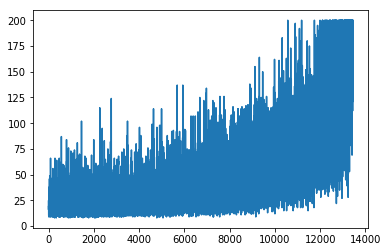

In [32]:
print("Average return: %.2f" % np.mean(returns))
print("Return std dev: %.2f" % np.std(returns))
#plot_durations(durations)
plt.plot(returns)

In [23]:
# Demonstration of policy
env = gym.make(env_name)
for ep in range(5):
    obs = env.reset()
    for t in range(env.spec.max_episode_steps):
        env.render()
        ac = sample_action(pnet, obs, discrete, device)
        if not discrete:
            ac = ac.numpy()
        obs, r, done, _ = env.step(ac)
        if done:
            break
env.close()